In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, ticker

# defaults sensibles para plots
green = cm.viridis

In [2]:
def rosenbrock(X, a=1, b=100):
    """
    Implementación de la función de Rosenbrock con parámetros
    a, b = 1 por default.

    Args:
        x: np array
        y: np array
        a: (opcional) parámetro a de la función Rosenbrock
        b: (opcional) parámetro b de la función Rosenbrock

    Returns: float
    """
    return (a-X[0])**2 + (b * (X[1] - X[0]**2))**2

Empezando por el extra:

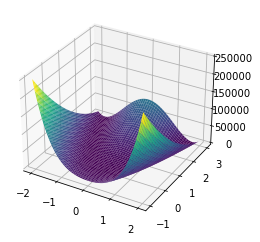

In [3]:
X, Y = np.mgrid[-2:2:0.01, -1:3:0.01]
Z = rosenbrock([X, Y])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,Z, cmap=green)

No es obvio porqué no es facil minimiar. Usamos contornos espaciados logarítmicamente

<ipython-input-4-1a76ef616afe>:2: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cm=green)
<ipython-input-4-1a76ef616afe>:2: UserWarning: The following kwargs were not used by contour: 'cm'
  cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cm=green)
<ipython-input-4-1a76ef616afe>:3: UserWarning: Log scale: values of z <= 0 have been masked
  cs2 = ax.contour(X, Y, Z, locator=ticker.LogLocator(), colors="k")


<a list of 5 text.Text objects>

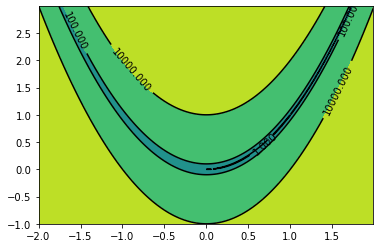

In [4]:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cm=green)
cs2 = ax.contour(X, Y, Z, locator=ticker.LogLocator(), colors="k")
ax.clabel(cs2)

Conclusión: Es fácil que el algoritmo se estanque en las regiones con forma de "u" y no siga descendiendo. En la región en la que se enciman los labels está el mínimo local. Pero empezando digamos en (0,0) dado que estaría un área donde no hay "dirección obvia" de descenso, es fácil que el algorimo concluya que es el mínimo en vez de explorar "más hacia en diagonal ascendente a la derecha"

### Usando búsqueda lineal con direción de Newton 

In [11]:
def Grad(f, x0, h=1e-6, i=-1):
    """
    Función que calcula el Grad de una función en un punto
    """
    n = len(x0)
    if i in range(n):
        z = np.zeros(n)
        z[i] = h/2
        Grad = (f(x0 + z) - f(x0 - z))/h
    else:
        Grad=np.zeros(n)
        for j in range(n):
            z = np.zeros(n)
            z[j] = h/2
            Grad[j]= (f(x0 + z) - f(x0 - z))/h
    return Grad


def Hess(f, x0, h=1e-4, method= "basic"):
    """
    Función que calcula la Hessiana  de una función en un punto. 

    Args:
        f: función sobre la cual queremos calcular la hessiana.
        x0: Punto sobre el cual queremos hacer el cálculo
        h: nivel de precisión para hacer el cálculo
        method: Método por el cual se quiere hacer puede ser: 'basic', 'grad', 'centered', 'gradCentered'
    """
    n = len(x0)
    Hess = np.matrix(np.zeros((n,n)))
    for i in range(n):
        for j in range(n):
            z_i = np.zeros(n)
            z_i[i] = h
            z_j = np.zeros(n)
            z_j[j] = h
            if method == "basic":
                Hess[i,j] = ( f(x0 + z_j +z_i) - f(x0 + z_i ) - f(x0+z_j) +f(x0)) / (h**2)
            elif method == "grad":
                Hess[i,j] = (Grad(f,x0+z_j,h,i) - Grad(f,x0,h,i) + \
                             Grad(f,x0+z_i,h,j) - Grad(f,x0,h,j))/(2*h)
            elif method == "centered":
                if i==j:
                    Hess[i,j] = (-f(x0+2*z_i) + 16*f(x0+z_i) - 30*f(x0)+\
                                 16*f(x0-z_i) - f(x0-2*z_i))  / (12*h**2)
                else :
                    Hess[i,j] = (f(x0+z_i+z_j) - f(x0 + z_i - z_j) - \
                                 f(x0 - z_i + z_j) + f(x0-z_i-z_j))/(4*h**2)
            elif method == "gradCentered":
                    Hess[i,j] = (Grad(f,x0+z_j,h)[i] - Grad(f, x0-z_j,h)[i] + \
                                 Grad(f,x0+z_i,h)[j] - Grad(f,x0-z_i,h)[j])/(4*h)
    return Hess

def genera_alpha(f, x0, pk, c1=1e-4, tol=1e-5):
    """
    Backtracking LS i.e. Algoritmo que encuentra una alpha que cumpla condiciones de wolfe. 
    """
    alpha, rho, c = 1, 4/5, c1
    while f(x0 + alpha*pk)>f(x0) + c*alpha*np.dot(Grad(f, x0),pk):
        alpha*=rho
    return alpha

def f_o_c(f,x, tol=1e-12):
    """
    Función que calcula las condiciones de primer orden
    """
    grad = np.array(Grad(f,x))
    return np.dot(grad, grad) < tol

def s_o_c(f, x0, tol=1e-15):
    """
    Función que calcula las condiciones de segundo orden
    """
    hess = Hess(f, x0, tol)
    return np.all(np.linalg.eigvals(hess) > tol)
    
def BL(f, x0, method="Busqueda Lineal"): 
    """
    Algoritmo de Newton (sin recorte de alpha)
    """
    # Inicializando el punto
    xk = x0
    # Cuento iteraciones porque el chiste es compararlos
    niters = 0
    # Tambien pongo iters maximos para que se vea que Newton falla
    max_iters = 10000

    while not (f_o_c(f,xk) and s_o_c(f,xk) and niters <= max_iters):

        # Uso la misma función porque casi todo el código es igual salvo generación de alpha
        if method=="Newton":
            # "centro" generación de alpha en algún punto constante para que no cambie.
            # No importa si no es un valor bonito, solo me importa que no cambie
            alpha_centro = x0
            max_iters = 9000
        elif method=="Busqueda Lineal":
            alpha_centro = xk
        else: # Asumo que el default es busqueda lineal
            alpha_centro = xk

        grad = Grad(f,xk)
        hess = Hess(f,xk)
        # En ambos casos usamos p_k^N como dirección de descenso
        pk_N = np.linalg.solve(hess, -grad)
        alpha = genera_alpha(f, alpha_centro, pk_N)
        xk = xk + alpha * pk_N

        niters += 1

    print(f"{niters} iteraciones")
    return xk

In [6]:
# Punto de inicio para la optimizacion
x0 = [0, 0]

In [7]:
BL_N = lambda f, x0: BL(f, x0, "Newton")
x_star_N = BL_N(rosenbrock, x0)
print(f"Encontrado minimo en {x_star_N} con método de Newton")

7527 iteraciones


array([0.99999964, 0.99999929])

In [8]:
BL_gen = lambda f, x0: BL(f, x0, "Busqueda Lineal")
x_star_BL = BL_gen(rosenbrock, x0);
print(f"Encontrado minimo en {x_star_BL} con método Busqueda lineal dirección newton con alpha de Armijo")

144 iteraciones


array([0.99999965, 0.9999993 ])

De acuerdo con wikipedia el mínimo es $(a, a^2)$, en este caso $(1, 1)$ por como parametrizamos Rosenbrock con a=1, b=100. Verificamos que $f(x,y) = 0$

In [9]:
print(rosenbrock(x_star))

1.2166379353671587e-13

Que básicamente es un cero numérico.

Conclusión: Newton con paso constante converge **mucho** más lento que con alpha determinado por condiciones de Armijo o descenso suficiente. No converge para puntos como [-1, 0] pero eso no lo puedo mostrar por restricciones de tiempo